# 03 Dynamic Time Warping 

In [1]:
import os
import sys
print(sys.version)

3.9.10 (main, Feb  9 2022, 11:11:48) 
[GCC 11.1.0]


In [94]:
import joblib
import warnings
from importlib import reload

import librosa
from librosa import time_to_frames, time_to_samples, frames_to_time, frames_to_samples

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [3]:
sys.path.append('./COMMON_UTILS/')

In [59]:
from utils import play, plot_audio

from drum_processor import getDownbeats

import tempo_align
reload(tempo_align)
from tempo_align import matchAudioEvents

In [34]:
plt.rcParams['figure.figsize'] = (15, 5)

### Load Audio

In [120]:
SRC = './PROCESSED/dem_bow/'

DST = './PROCESSED/gary_numan_electric/'

In [66]:
y, sr = librosa.load(os.path.join(SRC, 'DRUMS/drums.wav'), sr=44100)

In [122]:
y_dst, _ = librosa.load(os.path.join(DST, 'DRUMS/drums.wav'), sr=sr)

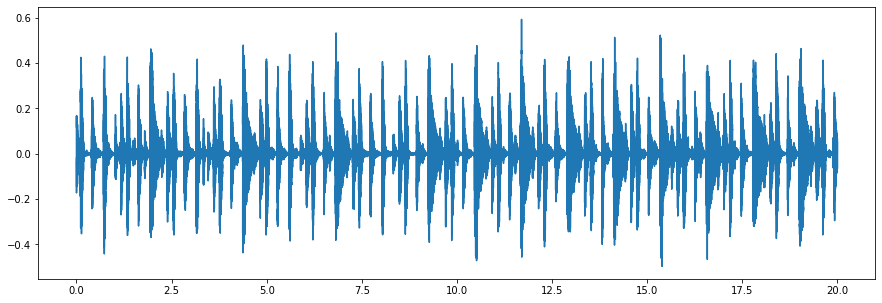

In [37]:
play(y, sr)
plot_audio(y, sr);

In [67]:
warnings.simplefilter("ignore")

db_src = getDownbeats(
    os.path.join(SRC, 'source.wav'), 
    transition_lambda=64, 
)

In [123]:
db_dst = getDownbeats(
    os.path.join(DST, 'source.wav'), 
    transition_lambda=64, 
)

### Warp Tests 

In [42]:
y_warped = matchAudioEvents(y, sr, [0.0, 5.0, 10.0], [1.0, 7.5, 15.0], hq=True)

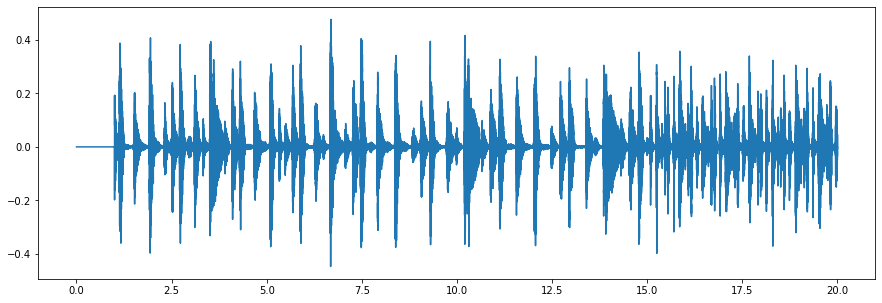

In [43]:
plot_audio(y_warped)
play(y_warped, sr)

### Event detection 

In [68]:
harm, perc = librosa.decompose.hpss(librosa.stft(y))

In [71]:
y_harm, y_perc = librosa.griffinlim(harm), librosa.griffinlim(perc)

In [72]:
play(y_harm, sr)
play(y_perc, sr)

In [126]:
def getRMSEvents(y, sr, hop_length=512):
    rms = librosa.feature.rms(y, hop_length=hop_length)[0]
    peaks, _ = find_peaks(rms, prominence=0.05)
    events = frames_to_time(peaks, sr=sr, hop_length=hop_length)
    
    return events

In [127]:
events_src = getRMSEvents(y, sr)
events_dst = getRMSEvents(y_dst, sr)

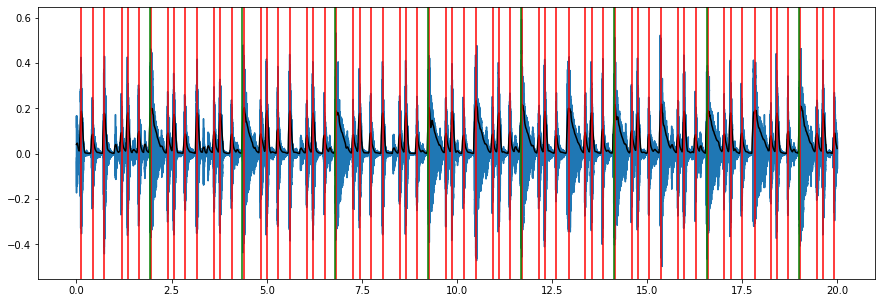

In [128]:
ax = plot_audio(y, sr)
plt.plot(frames_to_time(np.arange(len(rms)), sr=sr), rms, c='black')
for o in events_src:
    ax.axvline(o, color='red')
for d in db_src:
    ax.axvline(d, color="green")

In [187]:
def collectBarEvents(events, db, gs=48):
    bars = np.zeros((len(db) - 1, gs))
    for i in range(len(db) - 1):
        start = db[i]
        end = db[i+1]
        length = end - start
        b_onsets = events[np.where(np.logical_and(events >= start, events < end))]
        b_onsets -= start
        b_onsets /= length
        b_onsets = np.floor(b_onsets * gs).astype(int)
        
        bars[i, b_onsets] = 1.0

    return bars

In [188]:
b_events_src = collectBarEvents(events_src, db_src)

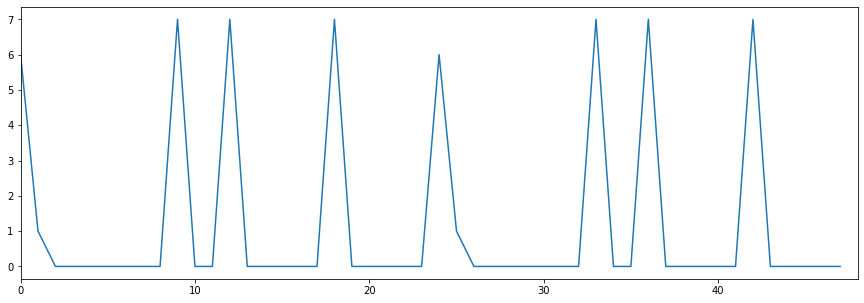

In [189]:
plt.plot(b_events_src.sum(0))
plt.xlim(0, 48);

In [190]:
b_events_dst = collectBarEvents(events_dst, db_dst)

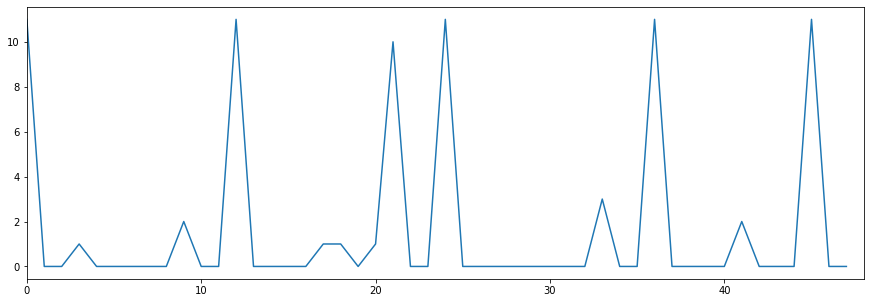

In [191]:
plt.plot(b_events_dst.sum(0))
plt.xlim(0, 48);